In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ppr.robot import Robot_2P3R,Robot_3R
from ppr.path import TrajectoryPt, TolerancedNumber
from ppr.geometry import Rectangle
from ppr.sampling import cart_to_joint, get_shortest_path

In [2]:
def get_new_bounds(l, u, m, red=4):
    """ create new interval smaller than the old one (l, u)
    reduced in length by a factor red.
    m is the value around wich the new interval should be centered
    the new interval may not go outside the old bounds
    """
    delta = abs(u - l) / red
    l_new = max(m - delta, l)
    u_new = min(m + delta, u)
    return l_new, u_new

def get_new_bounds_2(l, u, m, l_abs, u_abs, red=4):
    """ create new interval smaller than the old one (l, u)
    reduced in length by a factor red.
    m is the value around wich the new interval should be centered
    the new interval may not go outside the old bounds
    
    This function is not needed, if the bounds l, u start in the right interval,
    they will never go outside it without having to use the original bounds?
    """
    delta = abs(u - l) / red
    l_new = max(m - delta, l_abs)
    u_new = min(m + delta, u_abs)
    return l_new, u_new

def resample_trajectory_point(tp, pfk, *arg, **kwarg):
    """ create a new trajectory point with smaller bounds,
    but same sample number
    use the value from the forward kinematics pfk as the center
    of the new interval
    """
    p_new = []
    for i, val in enumerate(tp.p):
        if tp.hasTolerance[i]:
            # check for rounding errors on pfk
            if pfk[i] < val.l:
                pfk[i] = val.l
            if pfk[i] > val.u:
                pfk[i] = val.u
            l, u = get_new_bounds(val.l, val.u, pfk[i], *arg, **kwarg)
            val_new = TolerancedNumber(pfk[i], l, u, samples=val.s)
        else:
            val_new = val
        p_new.append(val_new)
    return TrajectoryPt(p_new)

def resample_path(path, q_sol, robot, *arg, **kwarg):
    poses = [robot.fk(q) for q in q_sol]
    path_new = []
    for i, tp in enumerate(path1):
        path_new.append(resample_trajectory_point(tp, poses[i], *arg, **kwarg))
    
    return path_new

def t2c(robot, path, scene, rsi=None):    
    # get discrete version of trajectory points
    discrete_path = []
    for pt in path:
        discrete_path.append(pt.discretise())
    
    # solve inverse kinematics for every samples traj point
    # I could add some print statements to have info on unreachable points
    joint_traj = []
    for i, cart_vec in enumerate(discrete_path):
        qi = []
        
        # set sampling information for redundant joints
        if rsi == None:
            jl1, jl2 = robot.jl
            q1 = TolerancedNumber(jl1[0], jl1[0], jl1[1], samples=robot.ik_samples[0])
            q2 = TolerancedNumber(jl2[0], jl2[0], jl2[1], samples=robot.ik_samples[1])
        else:
            q1 = TolerancedNumber(rsi[i][0, 0], rsi[i][0, 1], rsi[i][0, 2],
                                  samples=robot.ik_samples[0])
            q2 = TolerancedNumber(rsi[i][1, 0], rsi[i][1, 1], rsi[i][1, 2],
                                  samples=robot.ik_samples[1])
        
        
        for cart_pt in cart_vec:
            sol = robot.ik_redundant(cart_pt, [q1, q2])
            if sol['success']:
                for qsol in sol['q']:
                    if not robot.check_collision(qsol, scene):
                        qi.append(qsol)
        joint_traj.append(np.array(qi))
    return joint_traj

def get_path_specific_joint_limits(qrp, joint_limits, rsi_prev):
    rsi_new = []
    for i, q in enumerate(qrp):
        jl1, jl2 = joint_limits[0], joint_limits[1]
        bnds1, bnds2 = rsi_prev[i][0, 1:], rsi_prev[i][1, 1:]
        # TODO
        # outer bound must still be normal joint limits !!
        # but the range can be determined with the new limits
        l1, u1 = get_new_bounds_2(bnds1[0], bnds1[1], q[0], jl1[0], jl1[1])
        l2, u2 = get_new_bounds_2(bnds2[0], bnds2[1], q[1], jl2[0], jl2[1])
        rsi_new.append(np.array([[q[0], l1, u1], [q[1], l2, u2]]))
    return rsi_new

In [3]:
# ROBOT
robot1 = Robot_2P3R([4, 0.9, 2, 1.2, 1])
robot1.set_joint_limits([(2.0, 3.0), (0.2, 0.9)])
robot1.ik_samples = [3, 5]

# PATH
dx    = TolerancedNumber(0.5, 0.3, 0.8, samples=4)
dy    = np.linspace(2, 2.5, 5)
angle = TolerancedNumber(0.0, -np.pi, np.pi, samples=20)
path1 = [TrajectoryPt([dx, yi, angle]) for yi in dy]

# COLLISION SCENE
sc1 = [Rectangle(1, 1, 1, 1.5, 0),
       Rectangle(3, 1, 1, 2.2, 0),
       Rectangle(0, 3.2, 4, 0.5, 0),
       Rectangle(0, 1, 0.2, 3.2, 0),
       Rectangle(0.2, 1, 0.8, 0.5, 0)]

In [4]:
jl1, jl2 = robot1.jl
rsi1 = [np.array([[jl1[0], jl1[0], jl1[1]],
                  [jl2[0], jl2[0], jl2[1]]])
       ] * len(path1)

path_js = t2c(robot1, path1, sc1, rsi = rsi1)
print([len(qp) for qp in path_js])

[16, 25, 24, 39, 78]


converting type of Q
True
0.9239904284477234


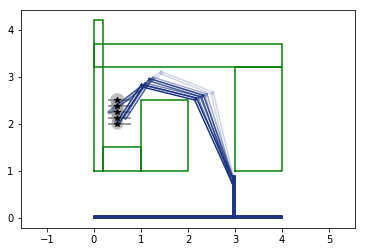

In [5]:
sol = get_shortest_path(path_js)
print(sol['success'])
print(sol['length'])

fig2, ax2 = plt.subplots()
ax2.axis('equal')
#robot1.plot_path_kinematics(ax2, path_js[2])
robot1.plot_path(ax2, sol['path'])
for r in sc1: r.plot(ax2, 'g')
for tp in path1: tp.plot(ax2)
plt.show()

In [6]:
rsi2 = get_path_specific_joint_limits(sol['path'], robot1.jl, rsi1)
for v in rsi2: print(v)

[[ 3.          2.75        3.        ]
 [ 0.72500002  0.55000002  0.9       ]]
[[ 3.          2.75        3.        ]
 [ 0.72500002  0.55000002  0.9       ]]
[[ 3.          2.75        3.        ]
 [ 0.72500002  0.55000002  0.9       ]]
[[ 3.          2.75        3.        ]
 [ 0.72500002  0.55000002  0.9       ]]
[[ 3.          2.75        3.        ]
 [ 0.72500002  0.55000002  0.9       ]]


In [7]:
sol['path']

[array([ 3.        ,  0.72500002,  0.42335284,  0.90444821, -5.0481081 ]),
 array([ 3.        ,  0.72500002,  0.34323344,  0.92826122, -4.99180174]),
 array([ 3.        ,  0.72500002,  0.3815482 ,  0.95114279, -5.38369226]),
 array([ 3.        ,  0.72500002,  0.30371672,  0.96609777, -5.32081556]),
 array([ 3.        ,  0.72500002,  0.23333894,  0.95897466, -5.24331474])]

[33, 53, 51, 70, 114]
converting type of Q
True
0.9239904284477234


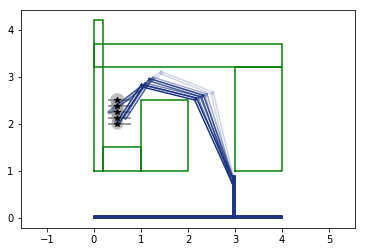

In [8]:
Q2 = t2c(robot1, path1, sc1, rsi=rsi2)
print([len(qp) for qp in Q2])

sol2 = get_shortest_path(Q2)
print(sol['success'])
print(sol['length'])

fig2, ax2 = plt.subplots()
ax2.axis('equal')
robot1.plot_path(ax2, sol2['path'])
for r in sc1: r.plot(ax2, 'g')
for tp in path1: tp.plot(ax2)
plt.show()

In [9]:
rsi3 = get_path_specific_joint_limits(sol2['path'], robot1.jl, rsi2)
for v in rsi3: print(v)
sol2['path']

[[ 3.          2.9375      3.        ]
 [ 0.72500002  0.63750003  0.81250002]]
[[ 3.          2.9375      3.        ]
 [ 0.72500002  0.63750003  0.81250002]]
[[ 3.          2.9375      3.        ]
 [ 0.72500002  0.63750003  0.81250002]]
[[ 3.          2.9375      3.        ]
 [ 0.72500002  0.63750003  0.81250002]]
[[ 3.          2.9375      3.        ]
 [ 0.72500002  0.63750003  0.81250002]]


[array([ 3.        ,  0.72500002,  0.42335284,  0.90444821, -5.0481081 ]),
 array([ 3.        ,  0.72500002,  0.34323344,  0.92826122, -4.99180174]),
 array([ 3.        ,  0.72500002,  0.3815482 ,  0.95114285, -5.38369226]),
 array([ 3.        ,  0.72500002,  0.30371672,  0.96609777, -5.32081556]),
 array([ 3.        ,  0.72500002,  0.23333894,  0.95897472, -5.24331474])]

[24, 49, 52, 73, 115]
converting type of Q
True
0.9239904284477234


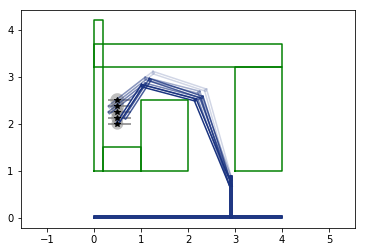

In [10]:
Q3 = t2c(robot1, path1, sc1, rsi=rsi3)
print([len(qp) for qp in Q3])

sol3 = get_shortest_path(Q3)
print(sol['success'])
print(sol['length'])

fig2, ax2 = plt.subplots()
ax2.axis('equal')
robot1.plot_path(ax2, sol3['path'])
for r in sc1: r.plot(ax2, 'g')
for tp in path1: tp.plot(ax2)
plt.show()

# other stuff

In [11]:
path2 = resample_path(path1, sol['path'], robot1, red=5)
robot1.set_joint_limits([(2.0, 3.0), (0.2, 0.9)])

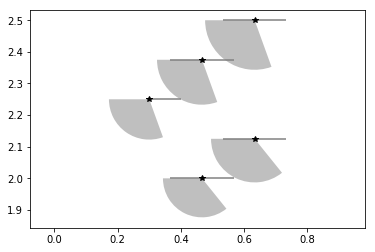

In [12]:
fig1, ax1 = plt.subplots()
ax1.axis('equal')
for tp in path2: tp.plot(ax1)
plt.show()

In [13]:
path_js_new = t2c(robot1, path2, sc1)
print([len(qp) for qp in path_js])

sol_new = get_shortest_path(path_js_new)
print(sol_new['success'])
print(sol_new['length'])

[16, 25, 24, 39, 78]
converting type of Q
True
0.5067678689956665


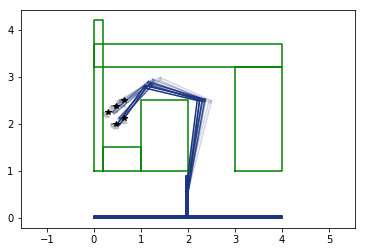

[array([ 2.        ,  0.55000001, -0.1262043 ,  1.46366119, -5.10301685]),
 array([ 2.        ,  0.55000001, -0.18040799,  1.46014512, -5.16365051]),
 array([ 2.        ,  0.55000001, -0.15127194,  1.4067682 , -5.2612443 ]),
 array([ 2.        ,  0.55000001, -0.18901005,  1.3933692 , -5.31105614]),
 array([ 2.        ,  0.55000001, -0.25306454,  1.39657426, -5.35115528])]

In [14]:
fig3, ax3 = plt.subplots()
ax3.axis('equal')
robot1.plot_path(ax3, sol_new['path'])
for r in sc1: r.plot(ax3, 'g')
for tp in path2: tp.plot(ax3)
plt.show()

sol_new['path']

In [15]:
current_path = path1
costs = []
for i in range(10):
    Q = cart_to_joint(robot1, current_path, check_collision=True, scene=sc1)
    sol = get_shortest_path(Q)
    if sol['success']:
        current_path = resample_path(current_path, sol['path'], robot1, red=10)
        costs.append(sol['length'])
    else:
        print("No solution in graph found")
print(costs)

converting type of Q
converting type of Q
converting type of Q
converting type of Q
converting type of Q
converting type of Q
converting type of Q
converting type of Q
converting type of Q
converting type of Q
[0.9239904284477234, 0.5184221863746643, 0.38470327854156494, 0.27350836992263794, 0.26496490836143494, 0.2642866373062134, 0.2646671235561371, 0.2642865478992462, 0.2646673023700714, 0.26428699493408203]


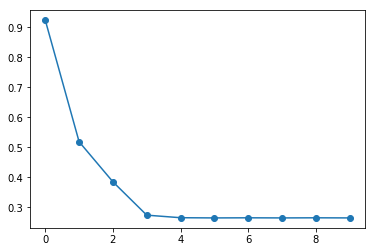

In [16]:
plt.plot(costs, 'o-')
plt.show()

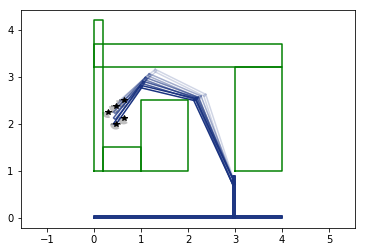

[array([ 3.        ,  0.72500002,  0.43455333,  0.90116   , -5.08908987]),
 array([ 3.        ,  0.72500002,  0.41597247,  0.8593514 , -5.09483862]),
 array([ 3.        ,  0.72500002,  0.40167287,  0.8116349 , -5.09896231]),
 array([ 3.        ,  0.72500002,  0.37014627,  0.79385257, -5.11579227]),
 array([ 3.        ,  0.72500002,  0.31632543,  0.79447776, -5.10436821])]

In [17]:
fig3, ax3 = plt.subplots()
ax3.axis('equal')
robot1.plot_path(ax3, sol['path'])
for r in sc1: r.plot(ax3, 'g')
for tp in path2: tp.plot(ax3)
plt.show()

sol['path']